In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_array
from scipy.sparse.linalg import spsolve

Matplotlib is building the font cache; this may take a moment.


In [2]:
# our first mesh
coords = np.array([[0,0],[1,0],[1,1],[0,1]])
elems = np.array([[0,2,1],[0,2,3]])

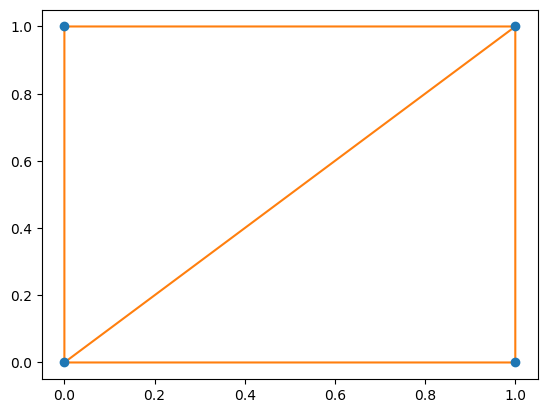

In [3]:
# plot mesh
plt.plot(coords[:,0],coords[:,1],'o')
plt.triplot(coords[:,0],coords[:,1],elems)

In [29]:
# extract the sides
def computeSides(coords,elems):
    sides = np.vstack([elems[:,[0,1]],elems[:,[1,2]],elems[:,[0,2]]])
    sides = np.sort(sides,axis=1)
    #sides = np.unique(sides,axis=0)
    sides, counts = np.unique(sides,axis=0,return_counts=True)
    intverts = np.setdiff1d(np.arange(coords.shape[0]),np.unique(sides[np.isclose(counts,np.ones(counts.shape)),:]))
    return sides, intverts

# refine the mesh
def refineMesh(coords, elems):
    sides, _ = computeSides(coords,elems)
    coords4mids = 0.5*coords[sides[:,0],:] + 0.5*coords[sides[:,1],:]
    newcoords = np.vstack([coords,coords4mids])
    
    side4vtx = csc_array((np.arange(coords.shape[0],coords.shape[0]+sides.shape[0]),(sides[:,0],sides[:,1])),shape=(coords.shape[0],coords.shape[0]))
    side4vtx = side4vtx + side4vtx.T
    
    newelems = np.zeros((4*elems.shape[0], 3),dtype=int)
    for k in range(elems.shape[0]):
        p0 = elems[k,0]
        p1 = elems[k,1]
        p2 = elems[k,2]
        p3 = side4vtx[p1,p2]
        p4 = side4vtx[p0,p2]
        p5 = side4vtx[p0,p1]
        newelems[4*(k+1)-4:4*(k+1),:] = np.array([[p0,p4,p5],[p5,p1,p3],[p4,p5,p3],[p4,p3,p2]])
    return newcoords, newelems

[5]
[0.5 0.5]


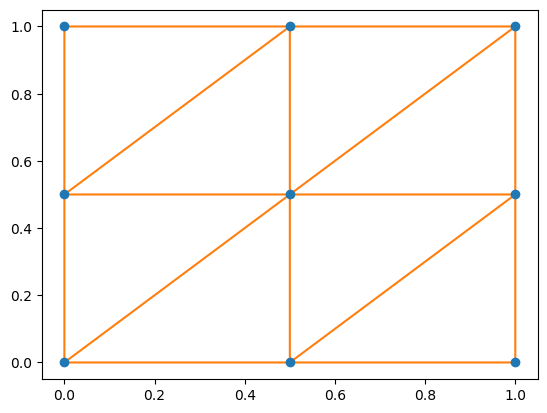

In [32]:
newcoords, newelems = refineMesh(coords,elems)
# plot refined mesh mesh
plt.plot(newcoords[:,0],newcoords[:,1],'o')
plt.triplot(newcoords[:,0],newcoords[:,1],newelems)
# compute interior vertices
_, intverts = computeSides(newcoords,newelems)
print(intverts)
print(newcoords[5,:])

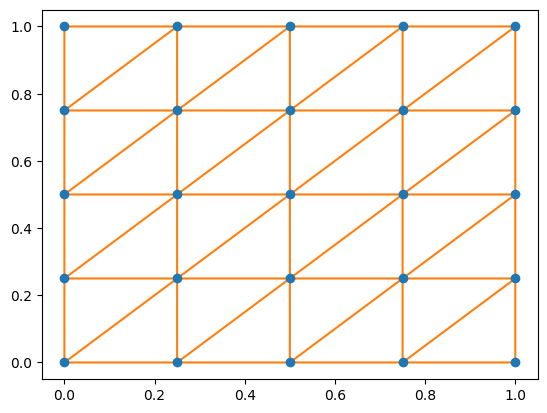

In [33]:
newcoords, newelems = refineMesh(newcoords,newelems)
# plot refined mesh mesh
plt.plot(newcoords[:,0],newcoords[:,1],'o')
plt.triplot(newcoords[:,0],newcoords[:,1],newelems)

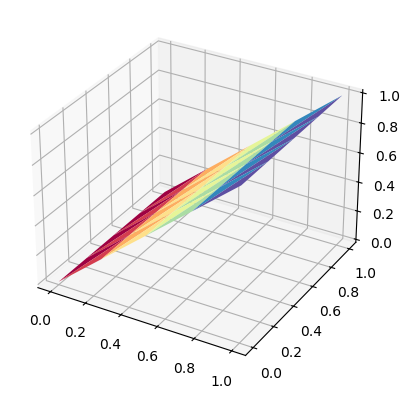

In [34]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot_trisurf(newcoords[:,0],newcoords[:,1],newcoords[:,0], triangles=newelems, cmap=plt.cm.Spectral,linewidth=1)
plt.show()

In [35]:
# Finite element stiffness matrix
def assembleSystemMatrix(coords,elems):
    S = csc_array((coords.shape[0],coords.shape[0])) 
    for k in range(elems.shape[0]):
        # compute ST
        # indeces of nonzero entries in ST
        idx = elems[k,:]
        rowidx = np.matlib.repmat(idx,3,1)
        colidx = np.transpose(rowidx).reshape(-1)
        rowidx = rowidx.reshape(-1)
        # comute entries of 3x3 local stiffness matrix
        # 
        DPhiT = np.array([[coords[elems[k,1],0]-coords[elems[k,0],0],coords[elems[k,2],0]-coords[elems[k,0],0]],
                          [coords[elems[k,1],1]-coords[elems[k,0],1],coords[elems[k,2],1]-coords[elems[k,0],1]]])
        C = np.linalg.solve(np.transpose(DPhiT),np.array([[-1,1,0],[-1,0,1]]))
        #print(C)
        #print(0.5 * np.abs(np.linalg.det(DPhiT)))
        STloc = 0.5 * np.abs(np.linalg.det(DPhiT)) * np.transpose(C)@C
        # embed them into ST
        ST = csc_array((STloc.reshape(-1), (rowidx,colidx)),shape=(coords.shape[0],coords.shape[0])) 
        #print(ST)
        # update S
        S = S + ST
    return S

# Finite element stiffness matrix
def assembleRightHandSide(coords,elems,f):
    r = np.zeros(coords.shape[0]) 
    for k in range(elems.shape[0]):
        # compute rT
        # indeces of nonzero entries in ST
        rowidx = elems[k,:]
        # comute entries of 3x3 local stiffness matrix
        DPhiT = np.array([[coords[elems[k,1],0]-coords[elems[k,0],0],coords[elems[k,2],0]-coords[elems[k,0],0]],
                          [coords[elems[k,1],1]-coords[elems[k,0],1],coords[elems[k,2],1]-coords[elems[k,0],1]]])
        rTloc = 0.5/3.0 * np.abs(np.linalg.det(DPhiT)) * (f[rowidx] @ np.ones(3))/3 * np.ones(3)
        # update r
        r[rowidx] = r[rowidx] + rTloc
    return r

In [79]:
def f(x):
    return 2*(x[:,0]*(np.ones(x.shape[0])-x[:,0])+x[:,1]*(np.ones(x.shape[0])-x[:,1])) 
    #np.ones(x.shape[0])#np.sin(x[:,0])

nref = 6
# create mesh
# our first mesh
coords = np.array([[0,0],[1,0],[1,1],[0,1]])
elems = np.array([[0,2,1],[0,2,3]])
for k in range(nref):
    coords, elems = refineMesh(coords,elems)

S = assembleSystemMatrix(coords,elems)
r = assembleRightHandSide(coords,elems,f(coords))
_ , dofs = computeSides(coords,elems)

uh = np.zeros(coords.shape[0])
uh[dofs] = spsolve(S[np.ix_(dofs,dofs)],r[dofs])

def u(x):
    return x[:,0]*(np.ones(x.shape[0])-x[:,0])*x[:,1]*(np.ones(x.shape[0])-x[:,1])
    
#print(np.max(np.abs(uh-u(coords[dofs,:]))))

eh = uh - u(coords)

H1err = np.sqrt(eh.T @ S @ eh) # only its nodal interpolation

print(H1err)

8.133405129864683e-05


In [80]:
# TODO: Build in boundary condition !!!

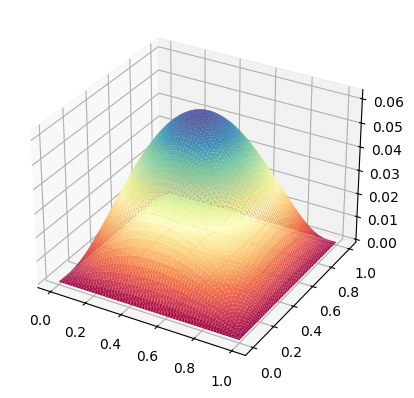

In [82]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot_trisurf(coords[:,1],coords[:,0],uh, triangles=elems, cmap=plt.cm.Spectral,linewidth=1)
plt.show()